In [1]:
import torch
import torch.nn as nn
# from apex import amp
from torch.cuda import amp
import numpy as np
from tqdm import tqdm
import torch
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from torch.autograd import Variable
from PIL import Image
from matplotlib.pyplot import imshow
from scipy import ndimage as ndi
from skimage.transform import resize
import pandas as pd
import os
import nibabel as nib


import matplotlib.pyplot as plt
%matplotlib inline

%gui qt

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Wed May 12 08:44:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:00:05.0 Off |                  N/A |
|  0%   25C    P0    57W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device= torch.device('cpu')
device

device(type='cuda')

# Import Data

In [5]:
dataDir = 'downloads/OpenDataset/'
# dataDir = 'drive/My Drive/B.Sc proj/OpenDataset/'
metadata = pd.read_csv(dataDir + '201014_M&Ms_Dataset_Information_-_opendataset.csv')
metadata

,External code,VendorName,Vendor,Centre,ED,ES
0,A0S9V9,Siemens,A,1,0,9
1,A1D0Q7,Philips,B,2,0,9
2,A1D9Z7,Siemens,A,1,22,11
3,A1E9Q1,Siemens,A,1,0,9
4,A1K2P5,Canon,D,5,33,11
...,...,...,...,...,...,...
340,T2Z1Z9,Canon,D,5,29,9
341,T9U9W2,Siemens,A,1,0,10
342,V4W8Z5,GE,C,4,19,9
343,W5Z4Z8,Philips,B,2,29,11


# Define Dataset

In [6]:
def normalize_01(inp: np.ndarray):
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def change_sizes(img, diff_seq, is_mask):
    img = img[:,:, diff_seq//2:img.shape[2]-(diff_seq-diff_seq//2)]
    res = []
    for i in range(img.shape[2]):
        x = resize(img[:,:, i], (200,200))
        res.append(x)
    return np.asarray(res)
    
def change_size_and_pad(img, diff_seq):
    res = []
    temp = np.zeros((200, 200))
    for i in range(diff_seq//2):
        res.append(temp)
    for i in range(img.shape[2]):
        x = resize(img[:,:, i], (200,200))
        res.append(x)
    for i in range(diff_seq - diff_seq//2):
        res.append(temp)
    return np.asarray(res)


def convert_two_class(x, inp_classes, target_class):
    for c in inp_classes:
        x[x == c] = target_class
    return x


p = dataDir + 'Validation/A5C2D2/A5C2D2_sa_gt.nii.gz'
a = nib.load(p).get_fdata()


class SegDataset(Dataset):
    def __init__(self, all_dirs, metadata, addr):
        self.all_dirs = all_dirs 
        self.metadata = metadata
        self.addr = addr
        self.num_seq = 8

    def get_class_weights(self):
        eps = 1e-6
        ones = np.sum(a == 1)
        zeros = np.sum(a == 0) + np.sum(a == 2) + np.sum(a == 3)
        
        return [ones / (ones + zeros + eps), zeros / (ones + zeros + eps)]

    def __len__(self):
        return 2*len(self.all_dirs)
    
    def __getitem__(self, idx):
        item = self.all_dirs[idx//2]
        path = self.addr + item

        mask, img, id = None, None, None

        ### lazy load data
        for root, dir, files in os.walk(path):
            for f in files:
                img_arr = nib.load(path + '/' + f).get_fdata()
#                 print(f"file name is {f}")
                if f[-8] == 't':
                    id = f.split('_')[0]
                    mask = img_arr
                else:
                    img = img_arr
        
        # preparing data 
#         print(f"df: {metadata[metadata['External code'] == id]['ES']}")
        if idx %2 == 0:
            t = metadata[metadata['External code'] == id]['ES'].iloc[0]
        else:
            t = metadata[metadata['External code'] == id]['ED'].iloc[0]
        
        img = img[:, :, :, t]
        gt = mask[:, :, :, t]


#         print('maximum number of mask', np.max(gt) , '\tmax of img', np.max(img))

        diff_seq = img.shape[2] - self.num_seq
        if diff_seq > 0: 
            img = change_sizes(img, diff_seq, False)
            gt = change_sizes(gt, diff_seq, True)
        else:
#             print(f'BEFORE shape of img is {img.shape} and shape of mask is {gt.shape}')
            img = change_size_and_pad(img, self.num_seq-img.shape[2])
            gt = change_size_and_pad(gt, self.num_seq-gt.shape[2])
        
        # print(f'AFTER shape of img is {img.shape} and shape of mask is {gt.shape}')

        img = normalize_01(img)
                

        # convert to tensors
        img = torch.FloatTensor([img])
        mask = torch.LongTensor([gt])

        # convert to 2 class format
        mask = convert_two_class(mask, [1,3], 0)
        mask[mask == 2] = 1
        mask = mask.float()# we only focus on class 1 
        # print('maxxxx minnnnn', torch.max(mask), torch.min(mask))

        return img, mask

# Load Dataset, DataLoader

In [7]:
batch_size = 4
num_epochs = 50
learning_rate = 0.001

UNLABELED = 4 

In [8]:
train_dir = dataDir + '/Training/Labeled/'
train_all = os.listdir(train_dir)
train_dataset = SegDataset(train_all, metadata, train_dir)


val_dir = dataDir + '/Validation/'
val_all = os.listdir(val_dir)[:8]
val_dataset = SegDataset(val_all, metadata, val_dir)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# Define Loss


In [9]:
def dice_score(inputs, targets, class_num, dims=[1,2,3], smooth=0.5):
    inputs = inputs.detach().clone()
    targets = targets.detach().clone()    
    
#     inputs = torch.argmax(inputs, dim=1)
#     print(f"check dimensions {inputs.shape}, {targets.shape}")



    inputs = torch.sigmoid(inputs)
    
    # round the probabilities to the closest integer
    # target = torch.round(target)
    inputs = torch.round(inputs)
    
#     print('min and max', torch.min(inputs), torch.max(inputs))
    
    inputs[inputs == class_num] = -1
    inputs[inputs != -1] = 0
    inputs[inputs != 0] = 1

    targets[targets == class_num] = -1
    targets[targets != -1] = 0
    targets[targets != 0] = 1   

#     print(f"inputs:{inputs}\ntargets:{targets}")

    intersection = 2 * (inputs * targets)
    total = (inputs + targets)
#     print(f"intersection: {intersection}\ntotal: {total}")
    
    intersection = intersection.sum(dim=dims)
    total = total.sum(dim=dims)
#     print(f"intersection: {intersection}\ntotal: {total}")

    dice = torch.add(intersection, smooth)/torch.add(total, smooth)
    
#     print('shape of dice', dice.shape)
    dice = torch.mean(dice).item()
#     print(dice)
    return dice  

In [10]:
import torch
from torch.nn import functional as F

smooth = 1e-2 # smooth value for dice_coef calculation

def dice_coef(outputs, target):

    # target: labels of current batch. can contain UNLABELED or probabilities.
    #     shape: (batch_size, 1, image_slices, width, height)
    
    # outputs: outputs of the model for current batch, without any activations.
    #     shape: (batch_size, 1, image_slices, width, height)
    
    # get the batch size
    batch_size = target.shape[0]
    
    # we calcaulate dice for each sample separately and return their sum.
    if batch_size > 1:
        result = dice_coef(outputs[0:1], target[0:1]) # dice of the first sample in batch
        for i in range(1, len(target)): # add dice of the other samples
            result = result + dice_coef(outputs[i:i+1], target[i:i+1])
        return result
    
    # convert `outputs` to probability
    outputs = torch.sigmoid(outputs)
    
    # round the probabilities to the closest integer
    # target = torch.round(target)
    outputs = torch.round(outputs)
    
    # shape of target and outputs will be (batch_size, 1, image_slices, width, height) here.
    #     containing the class of each voxel.
    
    # find the actual labeled voxels. 
    # labeled_voxels = target != UNLABELED
    # target = target[labeled_voxels]
    # outputs = outputs[labeled_voxels]
    
    # so now both target and outputs have only values 0 and 1 for background and liver respectively.

    
    # calculate intersection of target and outputs for each sample in batch
    intersection = (target * outputs).view(batch_size, -1).sum(-1).float()
    
    # calculate sum of target and outputs for each sample in batch
    union = (target + outputs).view(batch_size, -1).sum(-1).float()

    # numerator of dice_coef
    numerator = 2. * intersection + smooth

    # denominator of dice_coef
    denominator = union + smooth

    # calculate dice for each sample in batch
    coef = numerator / denominator
    
    # sum over samples in batch
    return coef.sum(0)


def soft_binray_cross_entropy(outputs, target, class_weights, voxel_weights=None):
    # target: labels of current batch. can contain UNLABELED or probabilities.
    #     shape: (batch_size, 1, image_slices, width, height)
    
    # outputs: outputs of the model for current batch, without any activations.
    #     shape: (batch_size, 1, image_slices, width, height)
    
    # class_weights: weights of classes. a tensor with shape (2, ). can't be None.
    
    # voxel_weights: a tensor with the exact shape of target's, containing a weight for each voxel. can be set to None.
    #     shape: (batch_size, 1, image_slices, width, height)
    
    # get the batch size
    batch_size = target.shape[0]
    
    # we calcaulate loss for each sample separately and return their sum.
    if batch_size > 1:
        # loss of the first sample in batch
        result = soft_binray_cross_entropy(
            outputs[0:1], 
            target[0:1], 
            class_weights, 
            None if voxel_weights is None else voxel_weights[0:1]
        )
        
        for i in range(1, len(target)): # add loss of the other samples
            result = result + soft_binray_cross_entropy(
                outputs[i:i+1], 
                target[i:i+1], 
                class_weights, 
                None if voxel_weights is None else voxel_weights[i:i+1]
            )
        return result
    
    # max(x, 0) - x * z + log(1 + exp(-abs(x)))
    outputs_positives = outputs.clone()
    outputs_positives[outputs_positives < 0] = 0.
    losses = outputs_positives - outputs * target + torch.log(1 + torch.exp(-torch.abs(outputs)))
    # print('shape of loss', loss.shape)
    
    # calculate strict target (round the probabilities to closest integers)
    # strict_target = torch.round(target)
    strict_target = target
    
    # initialize weights with zeros
    weights = torch.zeros_like(losses).to(target.device).float()
    
    # we set the weights of voxels according to their class
    # the weight of voxels with class `UNLABELED` will remain zero
    weights[strict_target == 0] = class_weights[0]
    weights[strict_target == 1] = class_weights[1]
    
    # apply voxel_weights if not None
    if voxel_weights is not None:
        weights = weights * voxel_weights
    
    # weighted mean
    return (losses * weights).sum() / weights.sum()

# Define UNet


In [11]:
import torch
import torch.nn as nn
# from apex import amp
from torch.cuda import amp
import numpy as np
from tqdm import tqdm

class UNet3D(nn.Module):
    def __init__(self, input_dim, output_dim, initial_filters=16, depth=4, dropout=0):
        # input_dim: number of input channles. 1 in our case.
        # output dim: number of output channels. 3 in our case. (since we have 3 labels)
        # initial_filter: kernel_size of the first conv. usually 16 or 32.
        # depth: depth of the U in unet. `image_slices` should be divisible by (2 ** depth)
        # dropout: the possibility of zeroing a node out.
        
        super(UNet3D, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.initial_filters = initial_filters
        self.depth = depth
        self.dropout = dropout
        activation = nn.ReLU(inplace=True)
        
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.trans = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        # Down
        for i in range(depth):
            in_dim = self.input_dim
            if i > 0:
                in_dim = self.initial_filters * 2 ** (i - 1)
            out_dim = self.initial_filters * 2 ** i
            self.downs.append(self.double_conv_block(in_dim, out_dim, activation))
            self.pools.append(self.max_pool())
            
        
        # Bridge
        self.bridge = self.double_conv_block(
            self.initial_filters * 2 ** (depth - 1),
            self.initial_filters * 2 ** depth,
            activation
        )
        
        # Dropout
        self.dropouts.append(self.dropout_layer())
        
        # Up
        for i in range(depth):
            trans_in_out_dim = self.initial_filters * 2 ** (depth - i)
            self.trans.append(self.conv_transpose_block(trans_in_out_dim, trans_in_out_dim, activation))
            
            up_in_dim = self.initial_filters * (2 ** (depth - i) + 2 ** (depth - i - 1))
            up_out_dim = self.initial_filters * 2 ** (depth - i - 1)
            self.ups.append(self.double_conv_block(up_in_dim, up_out_dim, activation))
            
        # Dropout
        self.dropouts.append(self.dropout_layer())
        
        # Output
        self.out = self.prediction_mask(initial_filters, self.output_dim)
        
        self.initialize_parameters()
        
        
    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.xavier_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias
        
    def single_conv_block(self, input_dim, output_dim, activation):
        return nn.Sequential(
            nn.Conv3d(input_dim, output_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(output_dim),
            activation
        )

    def double_conv_block(self, input_dim, output_dim, activation):
        return nn.Sequential(
            self.single_conv_block(input_dim, output_dim, activation),
            #nn.Dropout(p=self.dropout),
            self.single_conv_block(output_dim, output_dim, activation)
        )

    def conv_transpose_block(self, input_dim, output_dim, activation):
        return nn.Sequential(
            nn.ConvTranspose3d(input_dim, output_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm3d(output_dim),
            activation,
            #nn.Dropout(p=self.dropout)
        )

    def prediction_mask(self, input_dim, output_dim):
        # the activation is considered to in the loss.
        return nn.Conv3d(input_dim, output_dim, kernel_size=1, stride=1, padding=0) 

    def max_pool(self):
        return nn.MaxPool3d(kernel_size=2, stride=2, padding=0) 
    
    def dropout_layer(self):
        return nn.Dropout(p=self.dropout)
        
    def forward(self, x):
        downs = []
        ups = []
        pools = []
        trans = []
        concats = []
        dropouts = []
        
        # Down
        for i in range(self.depth):
            inp = x
            if i > 0:
                inp = pools[-1]
            downs.append(self.downs[i](inp))
            pools.append(self.pools[i](downs[-1]))
        
        # Bridge
        bridge = self.bridge(pools[-1])
        
        # Dropout
        dropouts.append(self.dropouts[0](bridge))
        
        # Up
        for i in range(self.depth):
            inp = dropouts[-1]
            if i > 0:
                inp = ups[-1]
            trans.append(self.trans[i](inp))
            concats.append(torch.cat([trans[-1], downs[self.depth - i - 1]], dim=1))
            ups.append(self.ups[i](concats[-1]))
        
        # Dropout
        dropouts.append(self.dropouts[1](ups[-1]))
        
        # Output
        out = self.out(dropouts[-1])
        return out


# Define Trainer

In [12]:
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []
        
        self.validation_dices_c0 = []


        self.train_dices_c0 = []
        
        cols = ['epoch', 't_dice_0', 't_dice_1', 't_dice_2', 't_dice_3', 'v_dice_0', 'v_dice_1', 'v_dice_2', 'v_dice_3', 't_loss', 'v_loss']
        self.log = pd.DataFrame(columns=cols)

        self.class_weights = torch.Tensor(training_DataLoader.dataset.get_class_weights()).cuda(0)
    


    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
            
            print(f"epoch number {self.epoch} finished with following results:")
            print('\ttrain dice ', self.train_dices_c0[i], '\tvalidation dice ', self.validation_dices_c0[i])
            print('\ttrain loss ', self.training_loss[i], '\tvalidation loss ', self.validation_loss[i])
            

            log_dict = {'epoch' : self.epoch,
                        't_dice_0': self.train_dices_c0[i],
                        'v_dice_0':self.validation_dices_c0[i], 
                        't_loss': self.training_loss[i], 'v_loss':self.validation_loss }
            
            self.log.append(log_dict, ignore_index=True)

            if i % 10 == 0 and i > 0:
                torch.save(self.model, dataDir + 'unet_3d_c2.pt')
                self.log.to_csv('log_2class_c2.csv')
                # self.dice_0_per_slice_log.to_csv('dice_0_per_slice_log.csv')
        
        
        self.log.to_csv('log_2class_c2.csv')
        return self.training_loss, self.validation_loss, self.validation_dices_c0

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here

        t_dices_c0 = []
        
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            # print('shape of input:', x.shape)
            # print('shape of output:', y.shape)
            input, target = x.to(0), y.to(0)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            # out = torch.argmax(out, dim=1)
            # out = torch.unsqueeze(out, 1)
            # print('**** shape of output:', out.shape)
            # print('**** shape of target:', target.shape)
#             loss = soft_binray_cross_entropy( 
#                     out,
#                     target, # target
#                     class_weights=self.class_weights,
#                     # voxel_weights=VW.cuda(self.gpu)
#                 )  # calculate loss
#             loss = Variable(loss.data, requires_grad=True)
            loss = criterion(out, target)
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters
            
#             t_dices_c0.append(dice_coef(out, target).item())
            t_dices_c0.append(dice_score(out, target,1))
                              
            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))

        self.train_dices_c0.append(np.mean(t_dices_c0))

        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        valid_dices_c0 = []
        
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                # out = torch.argmax(out, dim=1)
                # out = torch.unsqueeze(out, 1)
#                 loss = soft_binray_cross_entropy( 
#                     out,
#                     target, # target
#                     class_weights=self.class_weights,
#                     # voxel_weights=VW.cuda(self.gpu)
#                 )  # calculate loss
                loss = criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)
                
    
#                 valid_dices_c0.append(dice_coef(out, target).item())
                valid_dices_c0.append(dice_score(out, target,1))


                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))
        
        self.validation_dices_c0.append(np.mean(valid_dices_c0))
        
        batch_iter.close()

# Train

In [13]:
model = UNet3D(input_dim=1,
             output_dim=1,
             depth=3,
             dropout=0).to(device)

# model = torch.load(dataDir + 'unet_3d.pt')

In [14]:
# criterion
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = CostumLoss().to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_loader,
                  validation_DataLoader=val_loader,
                  lr_scheduler=None,
                  epochs=num_epochs,
                  epoch=0,
                  notebook=True)
# start training
training_losses, validation_losses, val_dices_0 = trainer.run_trainer()

epoch number 1 finished with following results:
	train dice  0.07909552140161395 	validation dice  0.23136355355381966
	train loss  0.5451027874151866 	validation loss  0.4208381325006485


epoch number 2 finished with following results:
	train dice  0.7236059482892354 	validation dice  0.7805801182985306
	train loss  0.3369964464505513 	validation loss  0.32631585747003555


epoch number 3 finished with following results:
	train dice  0.7392145729064942 	validation dice  0.7830802947282791
	train loss  0.2511232892672221 	validation loss  0.17206846922636032


epoch number 4 finished with following results:
	train dice  0.742101538181305 	validation dice  0.7842895090579987
	train loss  0.14932246913512548 	validation loss  0.11110479198396206


epoch number 5 finished with following results:
	train dice  0.7455493132273356 	validation dice  0.7837649434804916
	train loss  0.10302763730287552 	validation loss  0.0903135184198618


epoch number 6 finished with following results:
	train dice  0.7488398083051045 	validation dice  0.783432811498642
	train loss  0.08043382515509924 	validation loss  0.07672807574272156


epoch number 7 finished with following results:
	train dice  0.7476316793759664 	validation dice  0.7834328263998032
	train loss  0.06704904993375142 	validation loss  0.05839901603758335


epoch number 8 finished with following results:
	train dice  0.7544597109158834 	validation dice  0.7834328413009644
	train loss  0.05696909666061401 	validation loss  0.05574985686689615


epoch number 9 finished with following results:
	train dice  0.7577518630027771 	validation dice  0.7835565954446793
	train loss  0.050576639125744505 	validation loss  0.04925804678350687


epoch number 10 finished with following results:
	train dice  0.7644236914316813 	validation dice  0.8028513491153717
	train loss  0.04527933701872826 	validation loss  0.0512709291651845


epoch number 11 finished with following results:
	train dice  0.7701429239908855 	validation dice  0.7934437096118927
	train loss  0.04108796348174413 	validation loss  0.04325640294700861


epoch number 12 finished with following results:
	train dice  0.7818012793858846 	validation dice  0.7834327816963196
	train loss  0.03888075689474742 	validation loss  0.05171819217503071


epoch number 13 finished with following results:
	train dice  0.7869603705406188 	validation dice  0.7834361791610718
	train loss  0.036372318118810656 	validation loss  0.046969165094196796


epoch number 14 finished with following results:
	train dice  0.7873493933677673 	validation dice  0.7865934073925018
	train loss  0.0347056565930446 	validation loss  0.04320533853024244


epoch number 15 finished with following results:
	train dice  0.7973112106323242 	validation dice  0.8171578347682953
	train loss  0.032545785183707876 	validation loss  0.03163944045081735


epoch number 16 finished with following results:
	train dice  0.8110393786430359 	validation dice  0.8262597024440765
	train loss  0.03057751526435216 	validation loss  0.034457400906831026


epoch number 17 finished with following results:
	train dice  0.8188646451632182 	validation dice  0.821533739566803
	train loss  0.029291680827736855 	validation loss  0.03603826556354761


epoch number 18 finished with following results:
	train dice  0.8087592299779256 	validation dice  0.8071173876523972
	train loss  0.029565703372160593 	validation loss  0.03236445598304272


epoch number 19 finished with following results:
	train dice  0.8276990071932475 	validation dice  0.7973200082778931
	train loss  0.027176704555749893 	validation loss  0.03683740925043821


epoch number 20 finished with following results:
	train dice  0.8303754345575969 	validation dice  0.8240953832864761
	train loss  0.026215089447796346 	validation loss  0.030037382151931524


epoch number 21 finished with following results:
	train dice  0.8390566436449687 	validation dice  0.7782339751720428
	train loss  0.02487499105433623 	validation loss  0.03974294336512685


epoch number 22 finished with following results:
	train dice  0.8424100748697917 	validation dice  0.7962478846311569
	train loss  0.023902726136147977 	validation loss  0.0399558050557971


epoch number 23 finished with following results:
	train dice  0.8452225065231324 	validation dice  0.774956613779068
	train loss  0.023498752179245155 	validation loss  0.04395356075838208


epoch number 24 finished with following results:
	train dice  0.8485600741704306 	validation dice  0.8155643939971924
	train loss  0.022620505156616368 	validation loss  0.03757332731038332


epoch number 25 finished with following results:
	train dice  0.8528219413757324 	validation dice  0.8110707998275757
	train loss  0.021510099160174528 	validation loss  0.02980720018967986


epoch number 26 finished with following results:
	train dice  0.8471132779121399 	validation dice  0.8207369148731232
	train loss  0.02225988992800315 	validation loss  0.035881555173546076


epoch number 27 finished with following results:
	train dice  0.8434037033716838 	validation dice  0.8233359903097153
	train loss  0.022648814941445987 	validation loss  0.02948982361704111


epoch number 28 finished with following results:
	train dice  0.8609669955571493 	validation dice  0.8176696449518204
	train loss  0.02007748480886221 	validation loss  0.03516475111246109


epoch number 29 finished with following results:
	train dice  0.8575144108136495 	validation dice  0.8181418776512146
	train loss  0.020165151320397853 	validation loss  0.03068843111395836


epoch number 30 finished with following results:
	train dice  0.8684709962209066 	validation dice  0.8226133286952972
	train loss  0.019027757458388805 	validation loss  0.028458460699766874


epoch number 31 finished with following results:
	train dice  0.87753422498703 	validation dice  0.8107960969209671
	train loss  0.017735035965840022 	validation loss  0.037079112604260445


epoch number 32 finished with following results:
	train dice  0.8729896521568299 	validation dice  0.7892162054777145
	train loss  0.01777573273827632 	validation loss  0.043518449645489454


epoch number 33 finished with following results:
	train dice  0.873483058611552 	validation dice  0.7940758019685745
	train loss  0.017913088363905746 	validation loss  0.044335178565233946


epoch number 34 finished with following results:
	train dice  0.8781740474700928 	validation dice  0.8146130740642548
	train loss  0.01672921345879634 	validation loss  0.0376996798440814


epoch number 35 finished with following results:
	train dice  0.8665169890721639 	validation dice  0.7879997789859772
	train loss  0.01842531085014343 	validation loss  0.04069422697648406


epoch number 36 finished with following results:
	train dice  0.8739774243036906 	validation dice  0.7998795211315155
	train loss  0.01729885697364807 	validation loss  0.048493110574781895


epoch number 37 finished with following results:
	train dice  0.8706659507751465 	validation dice  0.7928367108106613
	train loss  0.017545821418364842 	validation loss  0.03299726406112313


epoch number 38 finished with following results:
	train dice  0.8757546877861023 	validation dice  0.7738596498966217
	train loss  0.017156781355539958 	validation loss  0.033223160076886415


epoch number 39 finished with following results:
	train dice  0.8686989736557007 	validation dice  0.764299675822258
	train loss  0.017903838840623697 	validation loss  0.03972381819039583


epoch number 40 finished with following results:
	train dice  0.8799063412348429 	validation dice  0.8126247227191925
	train loss  0.0164981422573328 	validation loss  0.0428747886326164


epoch number 41 finished with following results:
	train dice  0.8853123641014099 	validation dice  0.8022893816232681
	train loss  0.015289304206768672 	validation loss  0.038871121825650334


epoch number 42 finished with following results:
	train dice  0.8847969428698221 	validation dice  0.8063029497861862
	train loss  0.015673562691857417 	validation loss  0.04545695846900344


epoch number 43 finished with following results:
	train dice  0.8948933760325114 	validation dice  0.8052982538938522
	train loss  0.013875266555696725 	validation loss  0.040892723482102156


epoch number 44 finished with following results:
	train dice  0.8942886122067769 	validation dice  0.7856433391571045
	train loss  0.013769325378040473 	validation loss  0.04377200501039624


epoch number 45 finished with following results:
	train dice  0.8983151316642761 	validation dice  0.7960495799779892
	train loss  0.01335760780920585 	validation loss  0.04210668429732323


epoch number 46 finished with following results:
	train dice  0.9014991482098897 	validation dice  0.8180552423000336
	train loss  0.012729156476755937 	validation loss  0.038857782958075404


epoch number 47 finished with following results:
	train dice  0.8977238599459331 	validation dice  0.8176942765712738
	train loss  0.013269322104752063 	validation loss  0.036414481699466705


epoch number 48 finished with following results:
	train dice  0.9048174015680949 	validation dice  0.8116183429956436
	train loss  0.012390399438639482 	validation loss  0.04268600605428219


epoch number 49 finished with following results:
	train dice  0.9040160274505615 	validation dice  0.8052659630775452
	train loss  0.012466180721918742 	validation loss  0.040468509308993816


epoch number 50 finished with following results:
	train dice  0.8948679113388062 	validation dice  0.7913360595703125
	train loss  0.0132941042073071 	validation loss  0.04881764017045498



In [15]:
torch.save(model, dataDir + 'unet_3d_c2.pt')

In [16]:
model = torch.load(dataDir + 'unet_3d_c2.pt')

# Loss Plots

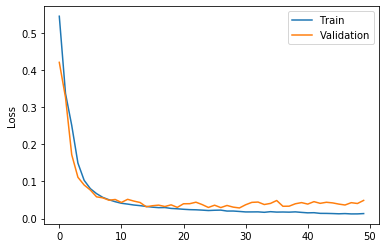

In [17]:
x_axis = range(0, num_epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, training_losses, label='Train')
ax.plot(x_axis, validation_losses, label='Validation')
ax.legend()
plt.ylabel('Loss')
plt.show()

# Show Results

In [18]:
from tqdm.notebook import tqdm, trange

model.eval()  # evaluation mode
batch_iter = tqdm(enumerate(val_loader), 'Validation', total=len(val_loader),
                    leave=False)

model_outputs = []
original_images = []
gts = []
dice_c0 = []
dice_c1 = []
dice_c2 = []
dice_c3 = []

for i, (x, y) in batch_iter:
    input, target = x.to(device), y.to(device)  # send to device (GPU or CPU)
    
    original_images.append(input.detach().clone())
    gts.append(target.detach().clone())
    
    with torch.no_grad():
        out = model(input)
        out = torch.sigmoid(out)
        out = torch.round(out)
        print(out.shape)
    
#     out_soft = torch.argmax(out, dim=1) 
#     model_outputs.append(out_soft)
    model_outputs.append(out)

    
#     dice_c0.append(dice_score(out.detach().clone(), target, 0))
    dice_c1.append(dice_score(out.detach().clone(), target, 1))
#     dice_c2.append(dice_score(out.detach().clone(), target, 2))
#     dice_c3.append(dice_score(out.detach().clone(), target, 3))


batch_iter.close()

torch.Size([4, 1, 8, 200, 200])
torch.Size([4, 1, 8, 200, 200])
torch.Size([4, 1, 8, 200, 200])
torch.Size([4, 1, 8, 200, 200])


In [19]:
model_outputs = np.asarray(model_outputs)
original_images = np.asarray(original_images)
gts = np.asarray(gts)

In [20]:
model_outputs[0].shape, original_images[0].shape, gts[0].shape

(torch.Size([4, 1, 8, 200, 200]),
 torch.Size([4, 1, 8, 200, 200]),
 torch.Size([4, 1, 8, 200, 200]))

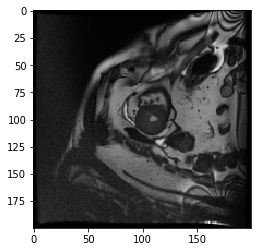

In [21]:
plt.imshow(original_images[0][2][0][6].cpu(), cmap='gray')

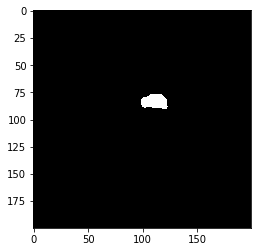

In [22]:
plt.imshow(gts[0][2][0][6].cpu(), cmap='gray')

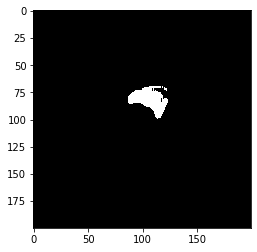

In [23]:
plt.imshow(model_outputs[0][1][0][6].cpu(), cmap='gray')

In [24]:
dice_c1

[0.8282490968704224,
 0.7499213814735413,
 0.7608261704444885,
 0.8263476490974426]